# SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages
We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables. We'll cover these in the next section.

## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('../Data/co2_mm_mlo.csv')

### Inspect the data, create a DatetimeIndex

In [2]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


We need to combine two integer columns (year and month) into a DatetimeIndex. We can do this by passing a dictionary into <tt>pandas.to_datetime()</tt> with year, month and day values.<br>
For more information visit https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

In [3]:
# Add a "date" datetime column
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [4]:
# Set "date" to be the index
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


### Plot the source data

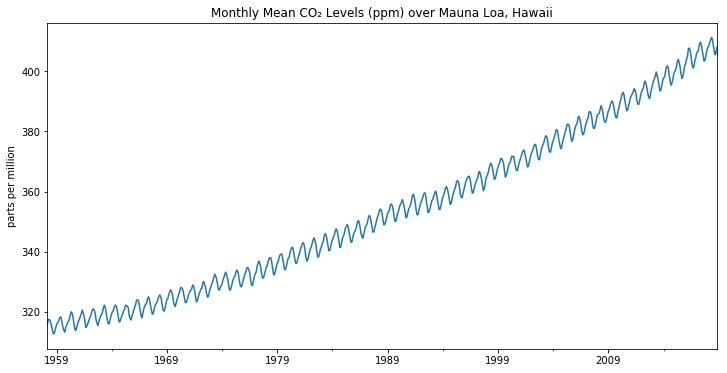

In [5]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Run an ETS Decomposition

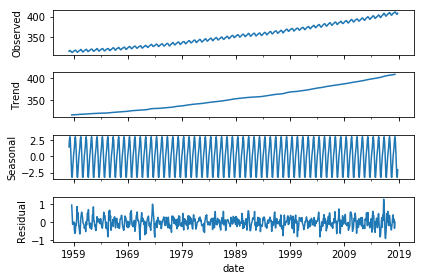

In [6]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

Although small in scale compared to the overall values, there is a definite annual seasonality.

### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot more combinations to evaluate.

In [7]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -207.450
Date:                            Sat, 22 Jan 2022   AIC                            424.900
Time:                                    00:54:04   BIC                            447.851
Sample:                                         0   HQIC                           433.756
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      1.000      0.317      -0.001       0.002
ma.L1         -0.3804      0.034    -11.143      0.000      -0.447      -0.313
ar.S.L12       0.9995      0.000   3160.246      0.000       0.999       1.000
ma.S.L12      -0.8644      0.022    -40.195      0.000      -0.907      -0.822
sigma2         0.0962      0.005     20.398      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       52.22   Jarque-Bera (JB):                 3.73
Prob(Q):                              0.09   Prob(JB):                         0.15
Heteroskedasticity (H):               1.12   Skew:                            -0.04
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Excellent! This provides an ARIMA Order of (0,1,3) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(0,1,3)(1,0,1,12) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

In [8]:
len(df)

729

In [9]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

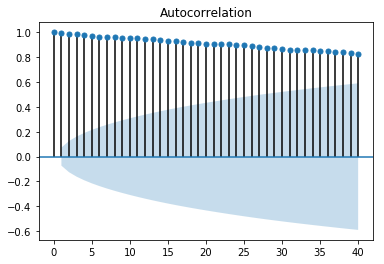

In [16]:
title = 'Autocorrelation'
lags = 40
plot_acf(df['interpolated'],title=title,lags=lags);

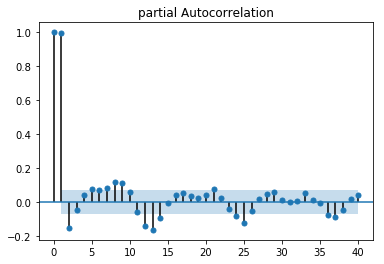

In [17]:
title = 'partial Autocorrelation'
lags = 40
plot_pacf(df['interpolated'],title=title,lags=lags);

### Fit a SARIMA(0,1,3)(1,0,1,12) Model

In [10]:
model = SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, 1, 12)   Log Likelihood                -201.188
Date:                            Sat, 22 Jan 2022   AIC                            414.376
Time:                                    00:54:06   BIC                            441.818
Sample:                                03-01-1958   HQIC                           424.973
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3541      0.036     -9.803      0.000      -0.425      -0.283
ma.L2         -0.0247      0.037     -0.662      0.508      -0.098       0.048
ma.L3         -0.0870      0.033     -2.601      0.009      -0.152      -0.021
ar.S.L12       0.9996      0.000   3100.063      0.000       0.999       1.000
ma.S.L12      -0.8663      0.023    -38.436      0.000      -0.910      -0.822
sigma2         0.0950      0.005     20.336      0.000       0.086       0.104
===================================================================================
Ljung-Box (Q):                       43.93   Jarque-Bera (JB):                 4.36
Prob(Q):                              0.31   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [12]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.6099972, expected=406.81
predicted=407.8251392, expected=407.96
predicted=408.5789761, expected=408.32
predicted=409.4839968, expected=409.41
predicted=411.0403472, expected=410.24
predicted=411.6433943, expected=411.24
predicted=410.8636968, expected=410.79
predicted=409.1738055, expected=408.71
predicted=407.0734861, expected=406.99
predicted=405.6231831, expected=405.51
predicted=405.8933876, expected=406.0
predicted=407.4268395, expected=408.02


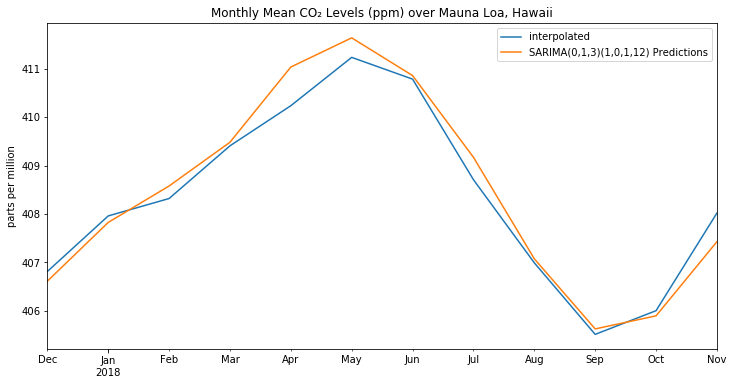

In [13]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate the Model

In [14]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 0.1281289987


In [15]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3579511122
